
# Sequence Extraction Using Pyfaidx


In [69]:
sample_count_threshold = 50;


## Imports & Path Set-up


In [70]:
import random
import math
import pandas as pd
from pyfaidx import Fasta
import matplotlib.pyplot as plt

PATH = '../GenomeData/'


## Preprocessed Data Handling


The provided data needs to be read into a pandas data frame for further processing...

In [71]:
ubsseq_data_raw = pd.read_excel("ubsseq_preprocessed_data.xlsx")
ubsseq_data_raw_shape = ubsseq_data_raw.shape

c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


The data needs to be filtered to remove genes that were not sampled enough to be statistically significant, this is determined by the unconverted/converted attribute. If the combined sum of these attributes is less than ??? then the gene has not shown enough influence from methylation to be considered.

In [72]:
ubsseq_data_sample_count = ubsseq_data_raw[['unconverted', 'converted']].sum(axis=1)
ubsseq_data_significant = ubsseq_data_raw[ubsseq_data_sample_count > sample_count_threshold]
ubsseq_data_significant_shape = ubsseq_data_significant.shape
print(f"Filtered data contains {ubsseq_data_significant_shape[0]} genes out of an initial {ubsseq_data_raw_shape[0]} genes, a {ubsseq_data_significant_shape[0]/ubsseq_data_raw_shape[0]*100:.2f}% retention")

Filtered data contains 1605 genes out of an initial 2140 genes, a 75.00% retention



## Ratio Control Selection


A scatter graph will show the correlation between the control ratio and NSUN6 ratio to help determine which genes should be selected for the positive data set. 
- Can do both a strict and relax cut-off.

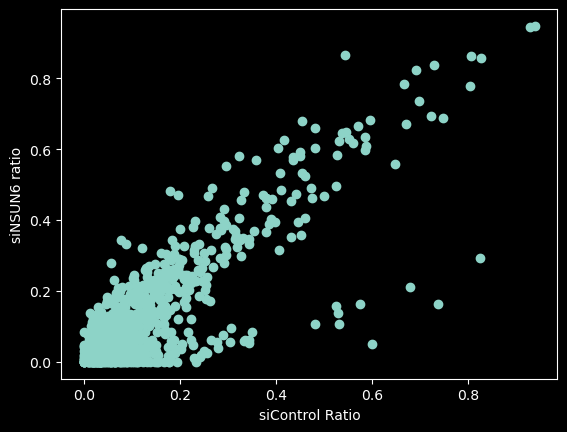

In [73]:
plt.scatter(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'])
plt.xlabel('siControl Ratio')
plt.ylabel('siNSUN6 ratio')
plt.show()

delta ratio will be (control - NSUN6) / control


## Sequence Extraction



## Saving Back To Fasta
